In [37]:
!pip install transformers==3.4.0

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [38]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import transformers
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np

In [39]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [40]:
train = pd.read_csv('../input/dataset-modified/train_modified.csv')
valid = pd.read_csv('../input/dataset-modified/val_modified.csv')
test = pd.read_csv('../input/dataset-modified/test_modified.csv')

xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [41]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = 'bert-base-multilingual-cased')
max_len = 200

xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [42]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(SGD(lr=1e-5), loss=loss, metrics=['accuracy'])

    return model

In [43]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_name = 'bert-base-multilingual-cased'
    config = BertConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    model = build_model(transformer_model)
    
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel ((None, 200, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 768)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 3076      
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32) 

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.3954 - accuracy: 0.21 - ETA: 2s - loss: 1.4029 - accuracy: 0.20 - ETA: 3s - loss: 1.3940 - accuracy: 0.26 - ETA: 4s - loss: 1.4006 - accuracy: 0.22 - ETA: 4s - loss: 1.4070 - accuracy: 0.22 - ETA: 4s - loss: 1.4046 - accuracy: 0.22 - ETA: 4s - loss: 1.4033 - accuracy: 0.22 - ETA: 4s - loss: 1.3966 - accuracy: 0.24 - ETA: 4s - loss: 1.3995 - accuracy: 0.23 - ETA: 4s - loss: 1.3980 - accuracy: 0.23 - ETA: 4s - loss: 1.3992 - accuracy: 0.22 - ETA: 4s - loss: 1.3991 - accuracy: 0.21 - ETA: 4s - loss: 1.4005 - accuracy: 0.21 - ETA: 4s - loss: 1.4028 - accuracy: 0.20 - ETA: 4s - loss: 1.4024 - accuracy: 0.21 - ETA: 4s - loss: 1.4012 - accuracy: 0.22 - ETA: 4s - loss: 1.4012 - accuracy: 0.21 - ETA: 4s - loss: 1.4016 - accuracy: 0.21 - ETA: 4s - loss: 1.4005 - accuracy: 0.22 - ETA: 4s - loss: 1.4011 - accuracy: 0.21 - ETA: 4s - loss: 1.4010 - accuracy: 0.21 - ETA: 4s - loss: 1.4005 - accuracy: 0.21 - ETA: 4s - loss: 1.4000 

Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.3918 - accuracy: 0.28 - ETA: 2s - loss: 1.4072 - accuracy: 0.17 - ETA: 3s - loss: 1.3942 - accuracy: 0.25 - ETA: 4s - loss: 1.3940 - accuracy: 0.25 - ETA: 4s - loss: 1.3923 - accuracy: 0.24 - ETA: 6s - loss: 1.3933 - accuracy: 0.22 - ETA: 6s - loss: 1.3918 - accuracy: 0.23 - ETA: 6s - loss: 1.3919 - accuracy: 0.23 - ETA: 6s - loss: 1.3926 - accuracy: 0.22 - ETA: 6s - loss: 1.3933 - accuracy: 0.22 - ETA: 5s - loss: 1.3911 - accuracy: 0.23 - ETA: 5s - loss: 1.3909 - accuracy: 0.24 - ETA: 5s - loss: 1.3908 - accuracy: 0.24 - ETA: 5s - loss: 1.3894 - accuracy: 0.25 - ETA: 5s - loss: 1.3891 - accuracy: 0.25 - ETA: 5s - loss: 1.3892 - accuracy: 0.25 - ETA: 5s - loss: 1.3898 - accuracy: 0.26 - ETA: 5s - loss: 1.3908 - accuracy: 0.26 - ETA: 5s - loss: 1.3906 - accuracy: 0.25 - ETA: 4s - loss: 1.3920 - accuracy: 0.25 - ETA: 4s - loss: 1.3916 - accuracy: 0.25 - ETA: 4s - loss: 1.3901 - accuracy: 0.26 - ETA: 4s - loss: 1.3899 

94/94 [==============================] - ETA: 0s - loss: 1.3917 - accuracy: 0.21 - ETA: 2s - loss: 1.3872 - accuracy: 0.28 - ETA: 3s - loss: 1.3801 - accuracy: 0.31 - ETA: 4s - loss: 1.3838 - accuracy: 0.28 - ETA: 4s - loss: 1.3862 - accuracy: 0.26 - ETA: 4s - loss: 1.3831 - accuracy: 0.28 - ETA: 4s - loss: 1.3824 - accuracy: 0.28 - ETA: 4s - loss: 1.3842 - accuracy: 0.26 - ETA: 4s - loss: 1.3826 - accuracy: 0.27 - ETA: 4s - loss: 1.3843 - accuracy: 0.26 - ETA: 4s - loss: 1.3844 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3888 - accuracy: 0.24 - ETA: 4s - loss: 1.3902 - accuracy: 0.24 - ETA: 4s - loss: 1.3910 - accuracy: 0.24 - ETA: 4s - loss: 1.3911 - accuracy: 0.24 - ETA: 4s - loss: 1.3910 - accuracy: 0.24 - ETA: 4s - loss: 1.3922 - accuracy: 0.24 - ETA: 4s - loss: 1.3931 - accuracy: 0.23 - ETA: 4s - loss: 1.3917 - accuracy: 0.24 - ETA: 4s - loss: 1.3929 - accuracy: 0.24 - ETA: 4s - loss: 1.3919 - accuracy: 0.24 - ETA: 4s - loss: 1.3923 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4097 - accuracy: 0.18 - ETA: 2s - loss: 1.4081 - accuracy: 0.18 - ETA: 3s - loss: 1.3957 - accuracy: 0.23 - ETA: 4s - loss: 1.3931 - accuracy: 0.24 - ETA: 4s - loss: 1.3934 - accuracy: 0.25 - ETA: 4s - loss: 1.3981 - accuracy: 0.23 - ETA: 4s - loss: 1.3989 - accuracy: 0.22 - ETA: 4s - loss: 1.3965 - accuracy: 0.23 - ETA: 4s - loss: 1.3927 - accuracy: 0.25 - ETA: 4s - loss: 1.3916 - accuracy: 0.25 - ETA: 4s - loss: 1.3919 - accuracy: 0.24 - ETA: 4s - loss: 1.3928 - accuracy: 0.24 - ETA: 4s - loss: 1.3935 - accuracy: 0.24 - ETA: 4s - loss: 1.3949 - accuracy: 0.24 - ETA: 4s - loss: 1.3939 - accuracy: 0.24 - ETA: 4s - loss: 1.3933 - accuracy: 0.25 - ETA: 4s - loss: 1.3937 - accuracy: 0.25 - ETA: 4s - loss: 1.3946 - accuracy: 0.24 - ETA: 4s - loss: 1.3955 - accuracy: 0.24 - ETA: 4s - loss: 1.3953 - accuracy: 0.24 - ETA: 4s - loss: 1.3942 - accuracy: 0.25 - ETA: 4s - loss: 1.3954 - accuracy: 0.24 - ETA: 4s - loss: 1.3957 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3789 - accuracy: 0.37 - ETA: 2s - loss: 1.3851 - accuracy: 0.34 - ETA: 3s - loss: 1.3843 - accuracy: 0.31 - ETA: 4s - loss: 1.3868 - accuracy: 0.30 - ETA: 4s - loss: 1.3832 - accuracy: 0.30 - ETA: 4s - loss: 1.3864 - accuracy: 0.29 - ETA: 4s - loss: 1.3867 - accuracy: 0.28 - ETA: 4s - loss: 1.3845 - accuracy: 0.29 - ETA: 4s - loss: 1.3827 - accuracy: 0.30 - ETA: 4s - loss: 1.3861 - accuracy: 0.28 - ETA: 4s - loss: 1.3885 - accuracy: 0.27 - ETA: 4s - loss: 1.3900 - accuracy: 0.26 - ETA: 4s - loss: 1.3900 - accuracy: 0.26 - ETA: 4s - loss: 1.3908 - accuracy: 0.26 - ETA: 4s - loss: 1.3923 - accuracy: 0.26 - ETA: 4s - loss: 1.3905 - accuracy: 0.26 - ETA: 4s - loss: 1.3923 - accuracy: 0.26 - ETA: 4s - loss: 1.3945 - accuracy: 0.25 - ETA: 4s - loss: 1.3950 - accuracy: 0.25 - ETA: 4s - loss: 1.3948 - accuracy: 0.25 - ETA: 4s - loss: 1.3949 - accuracy: 0.25 - ETA: 4s - loss: 1.3937 - accuracy: 0.25 - ETA: 4s - loss: 1.3929 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3934 - accuracy: 0.28 - ETA: 2s - loss: 1.4044 - accuracy: 0.17 - ETA: 6s - loss: 1.4015 - accuracy: 0.17 - ETA: 7s - loss: 1.3968 - accuracy: 0.21 - ETA: 7s - loss: 1.3993 - accuracy: 0.20 - ETA: 6s - loss: 1.3927 - accuracy: 0.23 - ETA: 6s - loss: 1.3931 - accuracy: 0.23 - ETA: 6s - loss: 1.3970 - accuracy: 0.22 - ETA: 6s - loss: 1.3967 - accuracy: 0.22 - ETA: 5s - loss: 1.3947 - accuracy: 0.23 - ETA: 5s - loss: 1.3948 - accuracy: 0.23 - ETA: 5s - loss: 1.3963 - accuracy: 0.22 - ETA: 5s - loss: 1.3981 - accuracy: 0.22 - ETA: 5s - loss: 1.3974 - accuracy: 0.23 - ETA: 5s - loss: 1.3961 - accuracy: 0.23 - ETA: 5s - loss: 1.3966 - accuracy: 0.23 - ETA: 5s - loss: 1.3968 - accuracy: 0.22 - ETA: 5s - loss: 1.3965 - accuracy: 0.23 - ETA: 5s - loss: 1.3963 - accuracy: 0.22 - ETA: 4s - loss: 1.3944 - accuracy: 0.23 - ETA: 4s - loss: 1.3945 - accuracy: 0.23 - ETA: 4s - loss: 1.3948 - accuracy: 0.22 - ETA: 4s - loss: 1.3940 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3908 - accuracy: 0.18 - ETA: 2s - loss: 1.3960 - accuracy: 0.20 - ETA: 3s - loss: 1.3944 - accuracy: 0.22 - ETA: 4s - loss: 1.3991 - accuracy: 0.20 - ETA: 4s - loss: 1.3968 - accuracy: 0.20 - ETA: 4s - loss: 1.3932 - accuracy: 0.21 - ETA: 4s - loss: 1.3913 - accuracy: 0.21 - ETA: 4s - loss: 1.3904 - accuracy: 0.21 - ETA: 4s - loss: 1.3893 - accuracy: 0.22 - ETA: 4s - loss: 1.3913 - accuracy: 0.20 - ETA: 4s - loss: 1.3923 - accuracy: 0.21 - ETA: 4s - loss: 1.3920 - accuracy: 0.20 - ETA: 4s - loss: 1.3913 - accuracy: 0.21 - ETA: 4s - loss: 1.3915 - accuracy: 0.21 - ETA: 4s - loss: 1.3924 - accuracy: 0.21 - ETA: 4s - loss: 1.3937 - accuracy: 0.20 - ETA: 4s - loss: 1.3931 - accuracy: 0.21 - ETA: 4s - loss: 1.3937 - accuracy: 0.21 - ETA: 4s - loss: 1.3937 - accuracy: 0.21 - ETA: 4s - loss: 1.3938 - accuracy: 0.21 - ETA: 4s - loss: 1.3938 - accuracy: 0.21 - ETA: 4s - loss: 1.3940 - accuracy: 0.21 - ETA: 4s - loss: 1.3932 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4011 - accuracy: 0.28 - ETA: 2s - loss: 1.4003 - accuracy: 0.23 - ETA: 3s - loss: 1.4002 - accuracy: 0.22 - ETA: 4s - loss: 1.3917 - accuracy: 0.24 - ETA: 4s - loss: 1.3872 - accuracy: 0.25 - ETA: 4s - loss: 1.3898 - accuracy: 0.25 - ETA: 4s - loss: 1.3894 - accuracy: 0.25 - ETA: 4s - loss: 1.3911 - accuracy: 0.25 - ETA: 4s - loss: 1.3890 - accuracy: 0.26 - ETA: 4s - loss: 1.3897 - accuracy: 0.26 - ETA: 4s - loss: 1.3904 - accuracy: 0.25 - ETA: 4s - loss: 1.3906 - accuracy: 0.25 - ETA: 4s - loss: 1.3914 - accuracy: 0.25 - ETA: 4s - loss: 1.3929 - accuracy: 0.24 - ETA: 4s - loss: 1.3909 - accuracy: 0.25 - ETA: 4s - loss: 1.3909 - accuracy: 0.24 - ETA: 4s - loss: 1.3921 - accuracy: 0.24 - ETA: 4s - loss: 1.3922 - accuracy: 0.24 - ETA: 4s - loss: 1.3915 - accuracy: 0.24 - ETA: 4s - loss: 1.3915 - accuracy: 0.24 - ETA: 4s - loss: 1.3924 - accuracy: 0.24 - ETA: 4s - loss: 1.3932 - accuracy: 0.24 - ETA: 4s - loss: 1.3943 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4018 - accuracy: 0.25 - ETA: 2s - loss: 1.3977 - accuracy: 0.23 - ETA: 3s - loss: 1.3972 - accuracy: 0.22 - ETA: 4s - loss: 1.3942 - accuracy: 0.25 - ETA: 4s - loss: 1.3934 - accuracy: 0.25 - ETA: 4s - loss: 1.3965 - accuracy: 0.24 - ETA: 4s - loss: 1.3971 - accuracy: 0.23 - ETA: 4s - loss: 1.3960 - accuracy: 0.24 - ETA: 4s - loss: 1.3937 - accuracy: 0.25 - ETA: 4s - loss: 1.3941 - accuracy: 0.25 - ETA: 4s - loss: 1.3942 - accuracy: 0.25 - ETA: 4s - loss: 1.3943 - accuracy: 0.24 - ETA: 4s - loss: 1.3955 - accuracy: 0.23 - ETA: 4s - loss: 1.3959 - accuracy: 0.23 - ETA: 4s - loss: 1.3945 - accuracy: 0.23 - ETA: 4s - loss: 1.3938 - accuracy: 0.24 - ETA: 4s - loss: 1.3936 - accuracy: 0.24 - ETA: 4s - loss: 1.3922 - accuracy: 0.25 - ETA: 4s - loss: 1.3921 - accuracy: 0.25 - ETA: 4s - loss: 1.3928 - accuracy: 0.24 - ETA: 4s - loss: 1.3933 - accuracy: 0.24 - ETA: 4s - loss: 1.3936 - accuracy: 0.24 - ETA: 4s - loss: 1.3934 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3593 - accuracy: 0.40 - ETA: 2s - loss: 1.3795 - accuracy: 0.32 - ETA: 3s - loss: 1.3878 - accuracy: 0.26 - ETA: 5s - loss: 1.3926 - accuracy: 0.25 - ETA: 6s - loss: 1.3958 - accuracy: 0.24 - ETA: 6s - loss: 1.3980 - accuracy: 0.23 - ETA: 6s - loss: 1.3976 - accuracy: 0.25 - ETA: 6s - loss: 1.3995 - accuracy: 0.23 - ETA: 5s - loss: 1.3978 - accuracy: 0.23 - ETA: 5s - loss: 1.3974 - accuracy: 0.24 - ETA: 5s - loss: 1.3970 - accuracy: 0.23 - ETA: 5s - loss: 1.3967 - accuracy: 0.23 - ETA: 5s - loss: 1.3956 - accuracy: 0.25 - ETA: 5s - loss: 1.3949 - accuracy: 0.24 - ETA: 5s - loss: 1.3961 - accuracy: 0.23 - ETA: 5s - loss: 1.3954 - accuracy: 0.24 - ETA: 5s - loss: 1.3952 - accuracy: 0.24 - ETA: 5s - loss: 1.3948 - accuracy: 0.24 - ETA: 4s - loss: 1.3957 - accuracy: 0.24 - ETA: 4s - loss: 1.3955 - accuracy: 0.23 - ETA: 4s - loss: 1.3949 - accuracy: 0.23 - ETA: 4s - loss: 1.3954 - accuracy: 0.23 - ETA: 4s - loss: 1.3963 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3962 - accuracy: 0.21 - ETA: 2s - loss: 1.3885 - accuracy: 0.25 - ETA: 3s - loss: 1.3899 - accuracy: 0.25 - ETA: 4s - loss: 1.3882 - accuracy: 0.25 - ETA: 4s - loss: 1.3894 - accuracy: 0.23 - ETA: 4s - loss: 1.3904 - accuracy: 0.24 - ETA: 4s - loss: 1.3920 - accuracy: 0.23 - ETA: 4s - loss: 1.3945 - accuracy: 0.23 - ETA: 4s - loss: 1.3949 - accuracy: 0.23 - ETA: 4s - loss: 1.3936 - accuracy: 0.24 - ETA: 4s - loss: 1.3950 - accuracy: 0.23 - ETA: 4s - loss: 1.3956 - accuracy: 0.23 - ETA: 4s - loss: 1.3952 - accuracy: 0.23 - ETA: 4s - loss: 1.3943 - accuracy: 0.23 - ETA: 4s - loss: 1.3946 - accuracy: 0.23 - ETA: 4s - loss: 1.3946 - accuracy: 0.23 - ETA: 4s - loss: 1.3930 - accuracy: 0.23 - ETA: 4s - loss: 1.3919 - accuracy: 0.23 - ETA: 4s - loss: 1.3917 - accuracy: 0.24 - ETA: 4s - loss: 1.3908 - accuracy: 0.25 - ETA: 4s - loss: 1.3913 - accuracy: 0.24 - ETA: 4s - loss: 1.3920 - accuracy: 0.24 - ETA: 4s - loss: 1.3913 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3967 - accuracy: 0.25 - ETA: 2s - loss: 1.3961 - accuracy: 0.23 - ETA: 3s - loss: 1.3922 - accuracy: 0.26 - ETA: 4s - loss: 1.3854 - accuracy: 0.29 - ETA: 4s - loss: 1.3803 - accuracy: 0.30 - ETA: 4s - loss: 1.3827 - accuracy: 0.28 - ETA: 4s - loss: 1.3855 - accuracy: 0.26 - ETA: 4s - loss: 1.3873 - accuracy: 0.25 - ETA: 4s - loss: 1.3855 - accuracy: 0.26 - ETA: 4s - loss: 1.3858 - accuracy: 0.25 - ETA: 4s - loss: 1.3843 - accuracy: 0.26 - ETA: 4s - loss: 1.3832 - accuracy: 0.28 - ETA: 4s - loss: 1.3817 - accuracy: 0.29 - ETA: 4s - loss: 1.3831 - accuracy: 0.28 - ETA: 4s - loss: 1.3842 - accuracy: 0.28 - ETA: 4s - loss: 1.3852 - accuracy: 0.27 - ETA: 4s - loss: 1.3856 - accuracy: 0.26 - ETA: 4s - loss: 1.3855 - accuracy: 0.26 - ETA: 4s - loss: 1.3856 - accuracy: 0.26 - ETA: 4s - loss: 1.3860 - accuracy: 0.26 - ETA: 4s - loss: 1.3860 - accuracy: 0.26 - ETA: 4s - loss: 1.3852 - accuracy: 0.26 - ETA: 4s - loss: 1.3856 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3822 - accuracy: 0.25 - ETA: 2s - loss: 1.3862 - accuracy: 0.26 - ETA: 3s - loss: 1.3810 - accuracy: 0.27 - ETA: 4s - loss: 1.3896 - accuracy: 0.22 - ETA: 4s - loss: 1.3895 - accuracy: 0.23 - ETA: 4s - loss: 1.3895 - accuracy: 0.23 - ETA: 4s - loss: 1.3883 - accuracy: 0.25 - ETA: 4s - loss: 1.3876 - accuracy: 0.25 - ETA: 4s - loss: 1.3891 - accuracy: 0.24 - ETA: 4s - loss: 1.3863 - accuracy: 0.26 - ETA: 4s - loss: 1.3853 - accuracy: 0.26 - ETA: 4s - loss: 1.3832 - accuracy: 0.27 - ETA: 4s - loss: 1.3824 - accuracy: 0.27 - ETA: 4s - loss: 1.3841 - accuracy: 0.27 - ETA: 4s - loss: 1.3851 - accuracy: 0.26 - ETA: 4s - loss: 1.3857 - accuracy: 0.26 - ETA: 4s - loss: 1.3860 - accuracy: 0.26 - ETA: 4s - loss: 1.3862 - accuracy: 0.25 - ETA: 4s - loss: 1.3862 - accuracy: 0.25 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3883 - accuracy: 0.24 - ETA: 4s - loss: 1.3873 - accuracy: 0.25 - ETA: 4s - loss: 1.3857 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3726 - accuracy: 0.31 - ETA: 2s - loss: 1.3774 - accuracy: 0.31 - ETA: 3s - loss: 1.3811 - accuracy: 0.30 - ETA: 6s - loss: 1.3788 - accuracy: 0.28 - ETA: 7s - loss: 1.3784 - accuracy: 0.29 - ETA: 7s - loss: 1.3800 - accuracy: 0.29 - ETA: 6s - loss: 1.3815 - accuracy: 0.29 - ETA: 6s - loss: 1.3822 - accuracy: 0.28 - ETA: 6s - loss: 1.3831 - accuracy: 0.27 - ETA: 6s - loss: 1.3843 - accuracy: 0.27 - ETA: 6s - loss: 1.3860 - accuracy: 0.26 - ETA: 6s - loss: 1.3864 - accuracy: 0.25 - ETA: 5s - loss: 1.3881 - accuracy: 0.24 - ETA: 5s - loss: 1.3872 - accuracy: 0.23 - ETA: 5s - loss: 1.3880 - accuracy: 0.23 - ETA: 5s - loss: 1.3875 - accuracy: 0.24 - ETA: 5s - loss: 1.3888 - accuracy: 0.23 - ETA: 5s - loss: 1.3887 - accuracy: 0.24 - ETA: 5s - loss: 1.3893 - accuracy: 0.23 - ETA: 5s - loss: 1.3894 - accuracy: 0.23 - ETA: 4s - loss: 1.3900 - accuracy: 0.23 - ETA: 4s - loss: 1.3905 - accuracy: 0.23 - ETA: 4s - loss: 1.3905 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3876 - accuracy: 0.28 - ETA: 5s - loss: 1.3908 - accuracy: 0.23 - ETA: 5s - loss: 1.3897 - accuracy: 0.23 - ETA: 5s - loss: 1.3865 - accuracy: 0.25 - ETA: 5s - loss: 1.3831 - accuracy: 0.26 - ETA: 5s - loss: 1.3852 - accuracy: 0.27 - ETA: 5s - loss: 1.3856 - accuracy: 0.26 - ETA: 5s - loss: 1.3853 - accuracy: 0.26 - ETA: 5s - loss: 1.3859 - accuracy: 0.26 - ETA: 5s - loss: 1.3861 - accuracy: 0.26 - ETA: 5s - loss: 1.3877 - accuracy: 0.25 - ETA: 4s - loss: 1.3857 - accuracy: 0.26 - ETA: 4s - loss: 1.3853 - accuracy: 0.26 - ETA: 4s - loss: 1.3856 - accuracy: 0.26 - ETA: 4s - loss: 1.3858 - accuracy: 0.26 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3844 - accuracy: 0.27 - ETA: 4s - loss: 1.3835 - accuracy: 0.27 - ETA: 4s - loss: 1.3843 - accuracy: 0.26 - ETA: 4s - loss: 1.3856 - accuracy: 0.26 - ETA: 4s - loss: 1.3846 - accuracy: 0.26 - ETA: 4s - loss: 1.3840 - accuracy: 0.26 - ETA: 4s - loss: 1.3836 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4100 - accuracy: 0.15 - ETA: 2s - loss: 1.3975 - accuracy: 0.25 - ETA: 3s - loss: 1.4001 - accuracy: 0.23 - ETA: 4s - loss: 1.3986 - accuracy: 0.24 - ETA: 4s - loss: 1.3979 - accuracy: 0.25 - ETA: 4s - loss: 1.3926 - accuracy: 0.28 - ETA: 4s - loss: 1.3932 - accuracy: 0.29 - ETA: 4s - loss: 1.3938 - accuracy: 0.26 - ETA: 4s - loss: 1.3927 - accuracy: 0.26 - ETA: 4s - loss: 1.3934 - accuracy: 0.26 - ETA: 4s - loss: 1.3943 - accuracy: 0.25 - ETA: 4s - loss: 1.3936 - accuracy: 0.25 - ETA: 4s - loss: 1.3955 - accuracy: 0.25 - ETA: 4s - loss: 1.3954 - accuracy: 0.24 - ETA: 4s - loss: 1.3953 - accuracy: 0.24 - ETA: 4s - loss: 1.3942 - accuracy: 0.25 - ETA: 4s - loss: 1.3941 - accuracy: 0.24 - ETA: 4s - loss: 1.3929 - accuracy: 0.24 - ETA: 4s - loss: 1.3929 - accuracy: 0.24 - ETA: 4s - loss: 1.3931 - accuracy: 0.24 - ETA: 4s - loss: 1.3916 - accuracy: 0.24 - ETA: 4s - loss: 1.3913 - accuracy: 0.24 - ETA: 4s - loss: 1.3916 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3672 - accuracy: 0.28 - ETA: 2s - loss: 1.3920 - accuracy: 0.21 - ETA: 3s - loss: 1.3969 - accuracy: 0.22 - ETA: 4s - loss: 1.3910 - accuracy: 0.24 - ETA: 4s - loss: 1.3922 - accuracy: 0.24 - ETA: 4s - loss: 1.3932 - accuracy: 0.25 - ETA: 4s - loss: 1.3923 - accuracy: 0.25 - ETA: 4s - loss: 1.3885 - accuracy: 0.26 - ETA: 4s - loss: 1.3886 - accuracy: 0.25 - ETA: 4s - loss: 1.3892 - accuracy: 0.25 - ETA: 4s - loss: 1.3869 - accuracy: 0.27 - ETA: 4s - loss: 1.3869 - accuracy: 0.26 - ETA: 4s - loss: 1.3875 - accuracy: 0.26 - ETA: 4s - loss: 1.3867 - accuracy: 0.25 - ETA: 4s - loss: 1.3877 - accuracy: 0.25 - ETA: 4s - loss: 1.3893 - accuracy: 0.24 - ETA: 4s - loss: 1.3900 - accuracy: 0.24 - ETA: 4s - loss: 1.3897 - accuracy: 0.24 - ETA: 4s - loss: 1.3903 - accuracy: 0.24 - ETA: 4s - loss: 1.3910 - accuracy: 0.23 - ETA: 4s - loss: 1.3919 - accuracy: 0.23 - ETA: 4s - loss: 1.3919 - accuracy: 0.23 - ETA: 4s - loss: 1.3911 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3825 - accuracy: 0.21 - ETA: 2s - loss: 1.3754 - accuracy: 0.25 - ETA: 3s - loss: 1.3834 - accuracy: 0.21 - ETA: 6s - loss: 1.3791 - accuracy: 0.23 - ETA: 7s - loss: 1.3799 - accuracy: 0.25 - ETA: 7s - loss: 1.3830 - accuracy: 0.24 - ETA: 6s - loss: 1.3817 - accuracy: 0.24 - ETA: 6s - loss: 1.3833 - accuracy: 0.24 - ETA: 6s - loss: 1.3838 - accuracy: 0.23 - ETA: 6s - loss: 1.3858 - accuracy: 0.23 - ETA: 6s - loss: 1.3857 - accuracy: 0.23 - ETA: 5s - loss: 1.3869 - accuracy: 0.22 - ETA: 5s - loss: 1.3885 - accuracy: 0.22 - ETA: 5s - loss: 1.3877 - accuracy: 0.23 - ETA: 5s - loss: 1.3882 - accuracy: 0.23 - ETA: 5s - loss: 1.3891 - accuracy: 0.22 - ETA: 5s - loss: 1.3891 - accuracy: 0.22 - ETA: 5s - loss: 1.3886 - accuracy: 0.23 - ETA: 5s - loss: 1.3886 - accuracy: 0.23 - ETA: 5s - loss: 1.3879 - accuracy: 0.24 - ETA: 4s - loss: 1.3876 - accuracy: 0.24 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3865 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3799 - accuracy: 0.28 - ETA: 2s - loss: 1.3894 - accuracy: 0.25 - ETA: 3s - loss: 1.3805 - accuracy: 0.28 - ETA: 4s - loss: 1.3810 - accuracy: 0.28 - ETA: 4s - loss: 1.3790 - accuracy: 0.27 - ETA: 4s - loss: 1.3813 - accuracy: 0.27 - ETA: 4s - loss: 1.3829 - accuracy: 0.27 - ETA: 4s - loss: 1.3844 - accuracy: 0.26 - ETA: 4s - loss: 1.3840 - accuracy: 0.27 - ETA: 4s - loss: 1.3843 - accuracy: 0.27 - ETA: 4s - loss: 1.3859 - accuracy: 0.27 - ETA: 4s - loss: 1.3848 - accuracy: 0.27 - ETA: 4s - loss: 1.3844 - accuracy: 0.27 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3840 - accuracy: 0.27 - ETA: 4s - loss: 1.3835 - accuracy: 0.27 - ETA: 4s - loss: 1.3838 - accuracy: 0.27 - ETA: 4s - loss: 1.3828 - accuracy: 0.27 - ETA: 4s - loss: 1.3825 - accuracy: 0.27 - ETA: 4s - loss: 1.3833 - accuracy: 0.27 - ETA: 4s - loss: 1.3836 - accuracy: 0.27 - ETA: 4s - loss: 1.3824 - accuracy: 0.27 - ETA: 4s - loss: 1.3827 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3835 - accuracy: 0.25 - ETA: 2s - loss: 1.3837 - accuracy: 0.26 - ETA: 3s - loss: 1.3888 - accuracy: 0.23 - ETA: 4s - loss: 1.3892 - accuracy: 0.25 - ETA: 4s - loss: 1.3928 - accuracy: 0.23 - ETA: 4s - loss: 1.3937 - accuracy: 0.21 - ETA: 4s - loss: 1.3934 - accuracy: 0.21 - ETA: 4s - loss: 1.3929 - accuracy: 0.23 - ETA: 4s - loss: 1.3906 - accuracy: 0.22 - ETA: 4s - loss: 1.3903 - accuracy: 0.23 - ETA: 4s - loss: 1.3895 - accuracy: 0.23 - ETA: 4s - loss: 1.3895 - accuracy: 0.23 - ETA: 4s - loss: 1.3889 - accuracy: 0.23 - ETA: 4s - loss: 1.3870 - accuracy: 0.24 - ETA: 4s - loss: 1.3869 - accuracy: 0.24 - ETA: 4s - loss: 1.3861 - accuracy: 0.24 - ETA: 4s - loss: 1.3852 - accuracy: 0.25 - ETA: 4s - loss: 1.3860 - accuracy: 0.25 - ETA: 4s - loss: 1.3861 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.24 - ETA: 4s - loss: 1.3871 - accuracy: 0.24 - ETA: 4s - loss: 1.3882 - accuracy: 0.24 - ETA: 4s - loss: 1.3881 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3881 - accuracy: 0.15 - ETA: 2s - loss: 1.3953 - accuracy: 0.15 - ETA: 3s - loss: 1.3960 - accuracy: 0.18 - ETA: 4s - loss: 1.3939 - accuracy: 0.17 - ETA: 4s - loss: 1.3944 - accuracy: 0.20 - ETA: 4s - loss: 1.3943 - accuracy: 0.19 - ETA: 4s - loss: 1.3910 - accuracy: 0.20 - ETA: 4s - loss: 1.3902 - accuracy: 0.20 - ETA: 4s - loss: 1.3888 - accuracy: 0.20 - ETA: 4s - loss: 1.3880 - accuracy: 0.22 - ETA: 4s - loss: 1.3885 - accuracy: 0.22 - ETA: 4s - loss: 1.3866 - accuracy: 0.23 - ETA: 4s - loss: 1.3869 - accuracy: 0.23 - ETA: 4s - loss: 1.3863 - accuracy: 0.24 - ETA: 4s - loss: 1.3873 - accuracy: 0.24 - ETA: 4s - loss: 1.3874 - accuracy: 0.24 - ETA: 4s - loss: 1.3891 - accuracy: 0.23 - ETA: 4s - loss: 1.3899 - accuracy: 0.23 - ETA: 4s - loss: 1.3899 - accuracy: 0.23 - ETA: 4s - loss: 1.3898 - accuracy: 0.23 - ETA: 4s - loss: 1.3899 - accuracy: 0.23 - ETA: 4s - loss: 1.3900 - accuracy: 0.22 - ETA: 4s - loss: 1.3897 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.28 - ETA: 2s - loss: 1.3919 - accuracy: 0.23 - ETA: 3s - loss: 1.3920 - accuracy: 0.22 - ETA: 4s - loss: 1.3919 - accuracy: 0.24 - ETA: 4s - loss: 1.3908 - accuracy: 0.26 - ETA: 4s - loss: 1.3872 - accuracy: 0.26 - ETA: 4s - loss: 1.3881 - accuracy: 0.25 - ETA: 4s - loss: 1.3891 - accuracy: 0.24 - ETA: 4s - loss: 1.3873 - accuracy: 0.25 - ETA: 4s - loss: 1.3874 - accuracy: 0.26 - ETA: 4s - loss: 1.3878 - accuracy: 0.26 - ETA: 4s - loss: 1.3876 - accuracy: 0.26 - ETA: 4s - loss: 1.3874 - accuracy: 0.26 - ETA: 4s - loss: 1.3884 - accuracy: 0.25 - ETA: 4s - loss: 1.3888 - accuracy: 0.25 - ETA: 4s - loss: 1.3887 - accuracy: 0.25 - ETA: 4s - loss: 1.3879 - accuracy: 0.25 - ETA: 4s - loss: 1.3873 - accuracy: 0.25 - ETA: 4s - loss: 1.3872 - accuracy: 0.26 - ETA: 4s - loss: 1.3872 - accuracy: 0.26 - ETA: 4s - loss: 1.3877 - accuracy: 0.26 - ETA: 4s - loss: 1.3876 - accuracy: 0.26 - ETA: 4s - loss: 1.3877 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3938 - accuracy: 0.18 - ETA: 2s - loss: 1.3874 - accuracy: 0.26 - ETA: 3s - loss: 1.3857 - accuracy: 0.27 - ETA: 4s - loss: 1.3891 - accuracy: 0.25 - ETA: 4s - loss: 1.3883 - accuracy: 0.25 - ETA: 4s - loss: 1.3881 - accuracy: 0.23 - ETA: 4s - loss: 1.3871 - accuracy: 0.25 - ETA: 4s - loss: 1.3847 - accuracy: 0.27 - ETA: 4s - loss: 1.3854 - accuracy: 0.28 - ETA: 4s - loss: 1.3860 - accuracy: 0.28 - ETA: 4s - loss: 1.3870 - accuracy: 0.27 - ETA: 4s - loss: 1.3859 - accuracy: 0.28 - ETA: 4s - loss: 1.3865 - accuracy: 0.28 - ETA: 4s - loss: 1.3850 - accuracy: 0.28 - ETA: 4s - loss: 1.3853 - accuracy: 0.28 - ETA: 4s - loss: 1.3858 - accuracy: 0.28 - ETA: 4s - loss: 1.3865 - accuracy: 0.27 - ETA: 4s - loss: 1.3869 - accuracy: 0.27 - ETA: 4s - loss: 1.3877 - accuracy: 0.26 - ETA: 4s - loss: 1.3870 - accuracy: 0.27 - ETA: 4s - loss: 1.3865 - accuracy: 0.27 - ETA: 4s - loss: 1.3871 - accuracy: 0.27 - ETA: 4s - loss: 1.3884 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3982 - accuracy: 0.18 - ETA: 2s - loss: 1.4001 - accuracy: 0.26 - ETA: 3s - loss: 1.3899 - accuracy: 0.32 - ETA: 4s - loss: 1.3875 - accuracy: 0.33 - ETA: 4s - loss: 1.3861 - accuracy: 0.31 - ETA: 4s - loss: 1.3863 - accuracy: 0.32 - ETA: 4s - loss: 1.3866 - accuracy: 0.32 - ETA: 4s - loss: 1.3857 - accuracy: 0.32 - ETA: 4s - loss: 1.3863 - accuracy: 0.29 - ETA: 4s - loss: 1.3868 - accuracy: 0.29 - ETA: 4s - loss: 1.3868 - accuracy: 0.29 - ETA: 4s - loss: 1.3865 - accuracy: 0.29 - ETA: 4s - loss: 1.3873 - accuracy: 0.28 - ETA: 4s - loss: 1.3874 - accuracy: 0.28 - ETA: 4s - loss: 1.3865 - accuracy: 0.28 - ETA: 4s - loss: 1.3878 - accuracy: 0.27 - ETA: 4s - loss: 1.3880 - accuracy: 0.27 - ETA: 4s - loss: 1.3875 - accuracy: 0.27 - ETA: 4s - loss: 1.3882 - accuracy: 0.26 - ETA: 4s - loss: 1.3883 - accuracy: 0.26 - ETA: 4s - loss: 1.3876 - accuracy: 0.27 - ETA: 4s - loss: 1.3876 - accuracy: 0.27 - ETA: 4s - loss: 1.3869 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4106 - accuracy: 0.0000e+ - ETA: 2s - loss: 1.3920 - accuracy: 0.1719   - ETA: 3s - loss: 1.4001 - accuracy: 0.16 - ETA: 4s - loss: 1.3994 - accuracy: 0.18 - ETA: 4s - loss: 1.3968 - accuracy: 0.20 - ETA: 4s - loss: 1.3964 - accuracy: 0.20 - ETA: 4s - loss: 1.3968 - accuracy: 0.21 - ETA: 4s - loss: 1.3952 - accuracy: 0.21 - ETA: 4s - loss: 1.3939 - accuracy: 0.22 - ETA: 4s - loss: 1.3938 - accuracy: 0.22 - ETA: 4s - loss: 1.3948 - accuracy: 0.21 - ETA: 4s - loss: 1.3930 - accuracy: 0.22 - ETA: 4s - loss: 1.3919 - accuracy: 0.23 - ETA: 4s - loss: 1.3919 - accuracy: 0.22 - ETA: 4s - loss: 1.3924 - accuracy: 0.22 - ETA: 4s - loss: 1.3926 - accuracy: 0.22 - ETA: 4s - loss: 1.3926 - accuracy: 0.22 - ETA: 4s - loss: 1.3921 - accuracy: 0.23 - ETA: 4s - loss: 1.3925 - accuracy: 0.22 - ETA: 4s - loss: 1.3911 - accuracy: 0.23 - ETA: 4s - loss: 1.3912 - accuracy: 0.23 - ETA: 4s - loss: 1.3914 - accuracy: 0.24 - ETA: 4s - loss: 1.3919 - ac

94/94 [==============================] - ETA: 0s - loss: 1.3907 - accuracy: 0.18 - ETA: 2s - loss: 1.3818 - accuracy: 0.23 - ETA: 3s - loss: 1.3907 - accuracy: 0.19 - ETA: 4s - loss: 1.3900 - accuracy: 0.21 - ETA: 4s - loss: 1.3885 - accuracy: 0.23 - ETA: 4s - loss: 1.3897 - accuracy: 0.22 - ETA: 4s - loss: 1.3870 - accuracy: 0.23 - ETA: 4s - loss: 1.3868 - accuracy: 0.23 - ETA: 4s - loss: 1.3863 - accuracy: 0.23 - ETA: 4s - loss: 1.3852 - accuracy: 0.24 - ETA: 4s - loss: 1.3856 - accuracy: 0.23 - ETA: 4s - loss: 1.3864 - accuracy: 0.23 - ETA: 4s - loss: 1.3862 - accuracy: 0.23 - ETA: 4s - loss: 1.3851 - accuracy: 0.23 - ETA: 4s - loss: 1.3858 - accuracy: 0.22 - ETA: 4s - loss: 1.3863 - accuracy: 0.23 - ETA: 4s - loss: 1.3863 - accuracy: 0.24 - ETA: 4s - loss: 1.3870 - accuracy: 0.23 - ETA: 4s - loss: 1.3867 - accuracy: 0.24 - ETA: 4s - loss: 1.3857 - accuracy: 0.24 - ETA: 4s - loss: 1.3856 - accuracy: 0.24 - ETA: 4s - loss: 1.3855 - accuracy: 0.24 - ETA: 4s - loss: 1.3855 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3882 - accuracy: 0.31 - ETA: 2s - loss: 1.3862 - accuracy: 0.26 - ETA: 3s - loss: 1.3919 - accuracy: 0.28 - ETA: 4s - loss: 1.3870 - accuracy: 0.27 - ETA: 4s - loss: 1.3857 - accuracy: 0.26 - ETA: 4s - loss: 1.3841 - accuracy: 0.27 - ETA: 4s - loss: 1.3866 - accuracy: 0.27 - ETA: 4s - loss: 1.3892 - accuracy: 0.26 - ETA: 4s - loss: 1.3895 - accuracy: 0.25 - ETA: 4s - loss: 1.3894 - accuracy: 0.25 - ETA: 4s - loss: 1.3895 - accuracy: 0.25 - ETA: 4s - loss: 1.3885 - accuracy: 0.25 - ETA: 4s - loss: 1.3894 - accuracy: 0.25 - ETA: 4s - loss: 1.3896 - accuracy: 0.25 - ETA: 4s - loss: 1.3890 - accuracy: 0.25 - ETA: 4s - loss: 1.3886 - accuracy: 0.25 - ETA: 4s - loss: 1.3881 - accuracy: 0.25 - ETA: 4s - loss: 1.3883 - accuracy: 0.25 - ETA: 4s - loss: 1.3884 - accuracy: 0.25 - ETA: 4s - loss: 1.3877 - accuracy: 0.25 - ETA: 4s - loss: 1.3860 - accuracy: 0.26 - ETA: 4s - loss: 1.3866 - accuracy: 0.26 - ETA: 4s - loss: 1.3868 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4030 - accuracy: 0.15 - ETA: 2s - loss: 1.3963 - accuracy: 0.21 - ETA: 3s - loss: 1.3893 - accuracy: 0.22 - ETA: 4s - loss: 1.3923 - accuracy: 0.22 - ETA: 4s - loss: 1.3911 - accuracy: 0.23 - ETA: 4s - loss: 1.3892 - accuracy: 0.25 - ETA: 4s - loss: 1.3873 - accuracy: 0.25 - ETA: 4s - loss: 1.3875 - accuracy: 0.24 - ETA: 4s - loss: 1.3854 - accuracy: 0.24 - ETA: 4s - loss: 1.3867 - accuracy: 0.23 - ETA: 4s - loss: 1.3860 - accuracy: 0.24 - ETA: 4s - loss: 1.3854 - accuracy: 0.25 - ETA: 4s - loss: 1.3847 - accuracy: 0.25 - ETA: 4s - loss: 1.3850 - accuracy: 0.25 - ETA: 4s - loss: 1.3847 - accuracy: 0.25 - ETA: 4s - loss: 1.3846 - accuracy: 0.25 - ETA: 4s - loss: 1.3844 - accuracy: 0.26 - ETA: 4s - loss: 1.3855 - accuracy: 0.25 - ETA: 4s - loss: 1.3863 - accuracy: 0.24 - ETA: 4s - loss: 1.3861 - accuracy: 0.24 - ETA: 4s - loss: 1.3866 - accuracy: 0.24 - ETA: 4s - loss: 1.3862 - accuracy: 0.25 - ETA: 4s - loss: 1.3852 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3914 - accuracy: 0.18 - ETA: 5s - loss: 1.3904 - accuracy: 0.21 - ETA: 5s - loss: 1.3924 - accuracy: 0.23 - ETA: 5s - loss: 1.3890 - accuracy: 0.24 - ETA: 5s - loss: 1.3920 - accuracy: 0.22 - ETA: 5s - loss: 1.3907 - accuracy: 0.23 - ETA: 5s - loss: 1.3924 - accuracy: 0.23 - ETA: 5s - loss: 1.3930 - accuracy: 0.22 - ETA: 5s - loss: 1.3924 - accuracy: 0.23 - ETA: 5s - loss: 1.3903 - accuracy: 0.23 - ETA: 5s - loss: 1.3914 - accuracy: 0.22 - ETA: 5s - loss: 1.3906 - accuracy: 0.22 - ETA: 5s - loss: 1.3905 - accuracy: 0.22 - ETA: 5s - loss: 1.3897 - accuracy: 0.23 - ETA: 4s - loss: 1.3910 - accuracy: 0.23 - ETA: 4s - loss: 1.3917 - accuracy: 0.23 - ETA: 4s - loss: 1.3908 - accuracy: 0.23 - ETA: 4s - loss: 1.3907 - accuracy: 0.23 - ETA: 4s - loss: 1.3909 - accuracy: 0.23 - ETA: 4s - loss: 1.3904 - accuracy: 0.23 - ETA: 4s - loss: 1.3900 - accuracy: 0.23 - ETA: 4s - loss: 1.3905 - accuracy: 0.24 - ETA: 4s - loss: 1.3904 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3756 - accuracy: 0.25 - ETA: 2s - loss: 1.3773 - accuracy: 0.23 - ETA: 3s - loss: 1.3799 - accuracy: 0.23 - ETA: 4s - loss: 1.3818 - accuracy: 0.23 - ETA: 4s - loss: 1.3808 - accuracy: 0.26 - ETA: 4s - loss: 1.3825 - accuracy: 0.27 - ETA: 4s - loss: 1.3801 - accuracy: 0.28 - ETA: 4s - loss: 1.3819 - accuracy: 0.28 - ETA: 4s - loss: 1.3832 - accuracy: 0.28 - ETA: 4s - loss: 1.3838 - accuracy: 0.28 - ETA: 4s - loss: 1.3825 - accuracy: 0.29 - ETA: 4s - loss: 1.3842 - accuracy: 0.28 - ETA: 4s - loss: 1.3873 - accuracy: 0.26 - ETA: 4s - loss: 1.3885 - accuracy: 0.26 - ETA: 4s - loss: 1.3891 - accuracy: 0.26 - ETA: 4s - loss: 1.3885 - accuracy: 0.26 - ETA: 4s - loss: 1.3881 - accuracy: 0.26 - ETA: 4s - loss: 1.3883 - accuracy: 0.26 - ETA: 4s - loss: 1.3877 - accuracy: 0.26 - ETA: 4s - loss: 1.3870 - accuracy: 0.26 - ETA: 4s - loss: 1.3868 - accuracy: 0.26 - ETA: 4s - loss: 1.3870 - accuracy: 0.26 - ETA: 4s - loss: 1.3866 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3790 - accuracy: 0.40 - ETA: 2s - loss: 1.3788 - accuracy: 0.35 - ETA: 3s - loss: 1.3758 - accuracy: 0.34 - ETA: 4s - loss: 1.3836 - accuracy: 0.30 - ETA: 4s - loss: 1.3862 - accuracy: 0.27 - ETA: 4s - loss: 1.3843 - accuracy: 0.28 - ETA: 4s - loss: 1.3859 - accuracy: 0.28 - ETA: 4s - loss: 1.3841 - accuracy: 0.29 - ETA: 4s - loss: 1.3833 - accuracy: 0.29 - ETA: 4s - loss: 1.3837 - accuracy: 0.28 - ETA: 4s - loss: 1.3837 - accuracy: 0.28 - ETA: 4s - loss: 1.3840 - accuracy: 0.28 - ETA: 4s - loss: 1.3843 - accuracy: 0.28 - ETA: 4s - loss: 1.3842 - accuracy: 0.29 - ETA: 4s - loss: 1.3841 - accuracy: 0.29 - ETA: 4s - loss: 1.3853 - accuracy: 0.28 - ETA: 4s - loss: 1.3853 - accuracy: 0.27 - ETA: 4s - loss: 1.3860 - accuracy: 0.27 - ETA: 4s - loss: 1.3864 - accuracy: 0.26 - ETA: 4s - loss: 1.3857 - accuracy: 0.26 - ETA: 4s - loss: 1.3858 - accuracy: 0.26 - ETA: 4s - loss: 1.3866 - accuracy: 0.26 - ETA: 4s - loss: 1.3861 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3816 - accuracy: 0.21 - ETA: 2s - loss: 1.3848 - accuracy: 0.23 - ETA: 3s - loss: 1.3803 - accuracy: 0.26 - ETA: 4s - loss: 1.3809 - accuracy: 0.26 - ETA: 4s - loss: 1.3785 - accuracy: 0.28 - ETA: 4s - loss: 1.3784 - accuracy: 0.27 - ETA: 4s - loss: 1.3772 - accuracy: 0.27 - ETA: 4s - loss: 1.3757 - accuracy: 0.28 - ETA: 4s - loss: 1.3779 - accuracy: 0.27 - ETA: 4s - loss: 1.3786 - accuracy: 0.27 - ETA: 4s - loss: 1.3805 - accuracy: 0.25 - ETA: 4s - loss: 1.3813 - accuracy: 0.25 - ETA: 4s - loss: 1.3818 - accuracy: 0.25 - ETA: 4s - loss: 1.3823 - accuracy: 0.25 - ETA: 4s - loss: 1.3823 - accuracy: 0.25 - ETA: 4s - loss: 1.3838 - accuracy: 0.25 - ETA: 4s - loss: 1.3838 - accuracy: 0.25 - ETA: 4s - loss: 1.3839 - accuracy: 0.25 - ETA: 4s - loss: 1.3838 - accuracy: 0.25 - ETA: 4s - loss: 1.3832 - accuracy: 0.26 - ETA: 4s - loss: 1.3833 - accuracy: 0.26 - ETA: 4s - loss: 1.3826 - accuracy: 0.26 - ETA: 4s - loss: 1.3831 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3920 - accuracy: 0.21 - ETA: 2s - loss: 1.3857 - accuracy: 0.26 - ETA: 3s - loss: 1.3855 - accuracy: 0.27 - ETA: 4s - loss: 1.3839 - accuracy: 0.29 - ETA: 4s - loss: 1.3831 - accuracy: 0.30 - ETA: 4s - loss: 1.3845 - accuracy: 0.28 - ETA: 4s - loss: 1.3844 - accuracy: 0.27 - ETA: 4s - loss: 1.3866 - accuracy: 0.26 - ETA: 4s - loss: 1.3859 - accuracy: 0.26 - ETA: 4s - loss: 1.3833 - accuracy: 0.27 - ETA: 4s - loss: 1.3829 - accuracy: 0.27 - ETA: 4s - loss: 1.3825 - accuracy: 0.27 - ETA: 4s - loss: 1.3824 - accuracy: 0.28 - ETA: 4s - loss: 1.3819 - accuracy: 0.27 - ETA: 4s - loss: 1.3814 - accuracy: 0.28 - ETA: 4s - loss: 1.3827 - accuracy: 0.27 - ETA: 4s - loss: 1.3830 - accuracy: 0.27 - ETA: 4s - loss: 1.3835 - accuracy: 0.26 - ETA: 4s - loss: 1.3837 - accuracy: 0.26 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3858 - accuracy: 0.26 - ETA: 4s - loss: 1.3870 - accuracy: 0.25 - ETA: 4s - loss: 1.3873 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.09 - ETA: 2s - loss: 1.3879 - accuracy: 0.23 - ETA: 3s - loss: 1.3945 - accuracy: 0.20 - ETA: 4s - loss: 1.3934 - accuracy: 0.23 - ETA: 4s - loss: 1.3935 - accuracy: 0.23 - ETA: 4s - loss: 1.3914 - accuracy: 0.23 - ETA: 4s - loss: 1.3911 - accuracy: 0.23 - ETA: 4s - loss: 1.3918 - accuracy: 0.23 - ETA: 4s - loss: 1.3917 - accuracy: 0.24 - ETA: 4s - loss: 1.3894 - accuracy: 0.25 - ETA: 4s - loss: 1.3902 - accuracy: 0.25 - ETA: 4s - loss: 1.3903 - accuracy: 0.25 - ETA: 4s - loss: 1.3888 - accuracy: 0.26 - ETA: 4s - loss: 1.3882 - accuracy: 0.26 - ETA: 4s - loss: 1.3882 - accuracy: 0.26 - ETA: 4s - loss: 1.3878 - accuracy: 0.26 - ETA: 4s - loss: 1.3887 - accuracy: 0.26 - ETA: 4s - loss: 1.3884 - accuracy: 0.25 - ETA: 4s - loss: 1.3896 - accuracy: 0.25 - ETA: 4s - loss: 1.3889 - accuracy: 0.24 - ETA: 4s - loss: 1.3890 - accuracy: 0.24 - ETA: 4s - loss: 1.3893 - accuracy: 0.24 - ETA: 4s - loss: 1.3892 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3989 - accuracy: 0.34 - ETA: 2s - loss: 1.3866 - accuracy: 0.32 - ETA: 3s - loss: 1.3813 - accuracy: 0.36 - ETA: 4s - loss: 1.3789 - accuracy: 0.35 - ETA: 4s - loss: 1.3833 - accuracy: 0.32 - ETA: 4s - loss: 1.3839 - accuracy: 0.31 - ETA: 4s - loss: 1.3862 - accuracy: 0.30 - ETA: 4s - loss: 1.3849 - accuracy: 0.30 - ETA: 4s - loss: 1.3845 - accuracy: 0.30 - ETA: 4s - loss: 1.3849 - accuracy: 0.30 - ETA: 5s - loss: 1.3845 - accuracy: 0.30 - ETA: 5s - loss: 1.3835 - accuracy: 0.30 - ETA: 5s - loss: 1.3827 - accuracy: 0.30 - ETA: 5s - loss: 1.3834 - accuracy: 0.29 - ETA: 5s - loss: 1.3845 - accuracy: 0.29 - ETA: 5s - loss: 1.3849 - accuracy: 0.28 - ETA: 5s - loss: 1.3865 - accuracy: 0.27 - ETA: 5s - loss: 1.3865 - accuracy: 0.27 - ETA: 5s - loss: 1.3876 - accuracy: 0.26 - ETA: 4s - loss: 1.3871 - accuracy: 0.27 - ETA: 4s - loss: 1.3872 - accuracy: 0.27 - ETA: 4s - loss: 1.3870 - accuracy: 0.27 - ETA: 4s - loss: 1.3864 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.21 - ETA: 2s - loss: 1.3711 - accuracy: 0.31 - ETA: 3s - loss: 1.3760 - accuracy: 0.29 - ETA: 4s - loss: 1.3839 - accuracy: 0.23 - ETA: 4s - loss: 1.3837 - accuracy: 0.22 - ETA: 4s - loss: 1.3867 - accuracy: 0.20 - ETA: 4s - loss: 1.3865 - accuracy: 0.20 - ETA: 4s - loss: 1.3856 - accuracy: 0.21 - ETA: 4s - loss: 1.3851 - accuracy: 0.22 - ETA: 4s - loss: 1.3881 - accuracy: 0.22 - ETA: 4s - loss: 1.3884 - accuracy: 0.22 - ETA: 4s - loss: 1.3896 - accuracy: 0.22 - ETA: 4s - loss: 1.3907 - accuracy: 0.22 - ETA: 4s - loss: 1.3919 - accuracy: 0.21 - ETA: 4s - loss: 1.3906 - accuracy: 0.22 - ETA: 4s - loss: 1.3900 - accuracy: 0.23 - ETA: 4s - loss: 1.3901 - accuracy: 0.23 - ETA: 4s - loss: 1.3904 - accuracy: 0.23 - ETA: 4s - loss: 1.3910 - accuracy: 0.22 - ETA: 4s - loss: 1.3913 - accuracy: 0.22 - ETA: 4s - loss: 1.3914 - accuracy: 0.22 - ETA: 4s - loss: 1.3901 - accuracy: 0.22 - ETA: 4s - loss: 1.3891 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3908 - accuracy: 0.25 - ETA: 2s - loss: 1.3984 - accuracy: 0.23 - ETA: 3s - loss: 1.3954 - accuracy: 0.21 - ETA: 4s - loss: 1.3933 - accuracy: 0.21 - ETA: 4s - loss: 1.3927 - accuracy: 0.20 - ETA: 4s - loss: 1.3888 - accuracy: 0.22 - ETA: 4s - loss: 1.3884 - accuracy: 0.21 - ETA: 4s - loss: 1.3890 - accuracy: 0.21 - ETA: 4s - loss: 1.3883 - accuracy: 0.21 - ETA: 4s - loss: 1.3849 - accuracy: 0.22 - ETA: 4s - loss: 1.3879 - accuracy: 0.22 - ETA: 4s - loss: 1.3878 - accuracy: 0.22 - ETA: 4s - loss: 1.3875 - accuracy: 0.22 - ETA: 4s - loss: 1.3871 - accuracy: 0.23 - ETA: 4s - loss: 1.3876 - accuracy: 0.23 - ETA: 4s - loss: 1.3880 - accuracy: 0.23 - ETA: 4s - loss: 1.3869 - accuracy: 0.24 - ETA: 4s - loss: 1.3855 - accuracy: 0.25 - ETA: 4s - loss: 1.3854 - accuracy: 0.25 - ETA: 4s - loss: 1.3851 - accuracy: 0.25 - ETA: 4s - loss: 1.3857 - accuracy: 0.24 - ETA: 4s - loss: 1.3862 - accuracy: 0.24 - ETA: 4s - loss: 1.3862 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3684 - accuracy: 0.40 - ETA: 2s - loss: 1.3723 - accuracy: 0.39 - ETA: 3s - loss: 1.3785 - accuracy: 0.35 - ETA: 4s - loss: 1.3792 - accuracy: 0.32 - ETA: 4s - loss: 1.3793 - accuracy: 0.31 - ETA: 4s - loss: 1.3812 - accuracy: 0.29 - ETA: 4s - loss: 1.3821 - accuracy: 0.29 - ETA: 4s - loss: 1.3804 - accuracy: 0.30 - ETA: 4s - loss: 1.3836 - accuracy: 0.28 - ETA: 4s - loss: 1.3850 - accuracy: 0.27 - ETA: 4s - loss: 1.3835 - accuracy: 0.28 - ETA: 4s - loss: 1.3836 - accuracy: 0.28 - ETA: 4s - loss: 1.3852 - accuracy: 0.27 - ETA: 4s - loss: 1.3848 - accuracy: 0.27 - ETA: 4s - loss: 1.3862 - accuracy: 0.26 - ETA: 4s - loss: 1.3873 - accuracy: 0.26 - ETA: 4s - loss: 1.3873 - accuracy: 0.26 - ETA: 4s - loss: 1.3870 - accuracy: 0.26 - ETA: 4s - loss: 1.3873 - accuracy: 0.25 - ETA: 4s - loss: 1.3871 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3877 - accuracy: 0.25 - ETA: 4s - loss: 1.3869 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3892 - accuracy: 0.25 - ETA: 2s - loss: 1.3826 - accuracy: 0.28 - ETA: 3s - loss: 1.3843 - accuracy: 0.28 - ETA: 4s - loss: 1.3870 - accuracy: 0.25 - ETA: 4s - loss: 1.3875 - accuracy: 0.25 - ETA: 4s - loss: 1.3868 - accuracy: 0.24 - ETA: 4s - loss: 1.3855 - accuracy: 0.25 - ETA: 4s - loss: 1.3856 - accuracy: 0.26 - ETA: 4s - loss: 1.3852 - accuracy: 0.25 - ETA: 4s - loss: 1.3857 - accuracy: 0.25 - ETA: 4s - loss: 1.3861 - accuracy: 0.25 - ETA: 4s - loss: 1.3870 - accuracy: 0.24 - ETA: 4s - loss: 1.3854 - accuracy: 0.25 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3860 - accuracy: 0.25 - ETA: 4s - loss: 1.3847 - accuracy: 0.26 - ETA: 4s - loss: 1.3843 - accuracy: 0.26 - ETA: 4s - loss: 1.3842 - accuracy: 0.26 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3858 - accuracy: 0.25 - ETA: 4s - loss: 1.3868 - accuracy: 0.24 - ETA: 4s - loss: 1.3868 - accuracy: 0.24 - ETA: 4s - loss: 1.3879 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3730 - accuracy: 0.28 - ETA: 2s - loss: 1.3854 - accuracy: 0.23 - ETA: 3s - loss: 1.3963 - accuracy: 0.19 - ETA: 4s - loss: 1.3939 - accuracy: 0.20 - ETA: 4s - loss: 1.3918 - accuracy: 0.21 - ETA: 4s - loss: 1.3902 - accuracy: 0.22 - ETA: 4s - loss: 1.3908 - accuracy: 0.20 - ETA: 4s - loss: 1.3884 - accuracy: 0.22 - ETA: 4s - loss: 1.3875 - accuracy: 0.22 - ETA: 4s - loss: 1.3872 - accuracy: 0.24 - ETA: 4s - loss: 1.3869 - accuracy: 0.24 - ETA: 4s - loss: 1.3871 - accuracy: 0.24 - ETA: 4s - loss: 1.3864 - accuracy: 0.24 - ETA: 4s - loss: 1.3858 - accuracy: 0.25 - ETA: 4s - loss: 1.3856 - accuracy: 0.25 - ETA: 5s - loss: 1.3851 - accuracy: 0.25 - ETA: 5s - loss: 1.3854 - accuracy: 0.26 - ETA: 5s - loss: 1.3857 - accuracy: 0.26 - ETA: 4s - loss: 1.3856 - accuracy: 0.26 - ETA: 4s - loss: 1.3853 - accuracy: 0.26 - ETA: 4s - loss: 1.3860 - accuracy: 0.26 - ETA: 4s - loss: 1.3861 - accuracy: 0.26 - ETA: 4s - loss: 1.3860 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4024 - accuracy: 0.15 - ETA: 2s - loss: 1.4051 - accuracy: 0.15 - ETA: 3s - loss: 1.3968 - accuracy: 0.21 - ETA: 4s - loss: 1.3945 - accuracy: 0.22 - ETA: 4s - loss: 1.3921 - accuracy: 0.23 - ETA: 4s - loss: 1.3909 - accuracy: 0.25 - ETA: 4s - loss: 1.3881 - accuracy: 0.27 - ETA: 4s - loss: 1.3885 - accuracy: 0.27 - ETA: 4s - loss: 1.3894 - accuracy: 0.27 - ETA: 4s - loss: 1.3891 - accuracy: 0.27 - ETA: 4s - loss: 1.3880 - accuracy: 0.27 - ETA: 4s - loss: 1.3868 - accuracy: 0.27 - ETA: 4s - loss: 1.3857 - accuracy: 0.27 - ETA: 4s - loss: 1.3860 - accuracy: 0.28 - ETA: 4s - loss: 1.3857 - accuracy: 0.27 - ETA: 4s - loss: 1.3859 - accuracy: 0.27 - ETA: 4s - loss: 1.3851 - accuracy: 0.27 - ETA: 4s - loss: 1.3847 - accuracy: 0.26 - ETA: 4s - loss: 1.3857 - accuracy: 0.26 - ETA: 4s - loss: 1.3857 - accuracy: 0.26 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3841 - accuracy: 0.27 - ETA: 4s - loss: 1.3856 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3786 - accuracy: 0.31 - ETA: 2s - loss: 1.3834 - accuracy: 0.29 - ETA: 3s - loss: 1.3903 - accuracy: 0.28 - ETA: 4s - loss: 1.3921 - accuracy: 0.26 - ETA: 4s - loss: 1.3876 - accuracy: 0.26 - ETA: 4s - loss: 1.3893 - accuracy: 0.25 - ETA: 4s - loss: 1.3885 - accuracy: 0.25 - ETA: 4s - loss: 1.3903 - accuracy: 0.24 - ETA: 4s - loss: 1.3872 - accuracy: 0.26 - ETA: 4s - loss: 1.3877 - accuracy: 0.25 - ETA: 4s - loss: 1.3883 - accuracy: 0.25 - ETA: 4s - loss: 1.3874 - accuracy: 0.25 - ETA: 4s - loss: 1.3867 - accuracy: 0.26 - ETA: 4s - loss: 1.3873 - accuracy: 0.25 - ETA: 4s - loss: 1.3875 - accuracy: 0.25 - ETA: 4s - loss: 1.3861 - accuracy: 0.24 - ETA: 4s - loss: 1.3855 - accuracy: 0.25 - ETA: 4s - loss: 1.3860 - accuracy: 0.24 - ETA: 4s - loss: 1.3855 - accuracy: 0.25 - ETA: 4s - loss: 1.3857 - accuracy: 0.25 - ETA: 4s - loss: 1.3853 - accuracy: 0.25 - ETA: 4s - loss: 1.3858 - accuracy: 0.25 - ETA: 4s - loss: 1.3860 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3984 - accuracy: 0.21 - ETA: 2s - loss: 1.3860 - accuracy: 0.26 - ETA: 3s - loss: 1.3789 - accuracy: 0.30 - ETA: 4s - loss: 1.3844 - accuracy: 0.26 - ETA: 4s - loss: 1.3887 - accuracy: 0.23 - ETA: 4s - loss: 1.3889 - accuracy: 0.23 - ETA: 4s - loss: 1.3863 - accuracy: 0.24 - ETA: 4s - loss: 1.3876 - accuracy: 0.24 - ETA: 4s - loss: 1.3855 - accuracy: 0.25 - ETA: 4s - loss: 1.3851 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.25 - ETA: 4s - loss: 1.3874 - accuracy: 0.24 - ETA: 4s - loss: 1.3875 - accuracy: 0.24 - ETA: 4s - loss: 1.3871 - accuracy: 0.24 - ETA: 4s - loss: 1.3859 - accuracy: 0.25 - ETA: 4s - loss: 1.3859 - accuracy: 0.25 - ETA: 4s - loss: 1.3860 - accuracy: 0.25 - ETA: 4s - loss: 1.3849 - accuracy: 0.25 - ETA: 4s - loss: 1.3852 - accuracy: 0.25 - ETA: 4s - loss: 1.3857 - accuracy: 0.25 - ETA: 4s - loss: 1.3857 - accuracy: 0.25 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3863 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3966 - accuracy: 0.18 - ETA: 2s - loss: 1.3943 - accuracy: 0.21 - ETA: 6s - loss: 1.3952 - accuracy: 0.21 - ETA: 7s - loss: 1.3909 - accuracy: 0.25 - ETA: 6s - loss: 1.3898 - accuracy: 0.26 - ETA: 6s - loss: 1.3921 - accuracy: 0.25 - ETA: 6s - loss: 1.3931 - accuracy: 0.24 - ETA: 6s - loss: 1.3930 - accuracy: 0.23 - ETA: 5s - loss: 1.3918 - accuracy: 0.23 - ETA: 5s - loss: 1.3924 - accuracy: 0.23 - ETA: 5s - loss: 1.3906 - accuracy: 0.24 - ETA: 5s - loss: 1.3904 - accuracy: 0.24 - ETA: 5s - loss: 1.3893 - accuracy: 0.25 - ETA: 5s - loss: 1.3890 - accuracy: 0.25 - ETA: 5s - loss: 1.3885 - accuracy: 0.26 - ETA: 5s - loss: 1.3891 - accuracy: 0.26 - ETA: 5s - loss: 1.3883 - accuracy: 0.26 - ETA: 5s - loss: 1.3884 - accuracy: 0.26 - ETA: 5s - loss: 1.3885 - accuracy: 0.26 - ETA: 4s - loss: 1.3888 - accuracy: 0.26 - ETA: 4s - loss: 1.3875 - accuracy: 0.26 - ETA: 4s - loss: 1.3877 - accuracy: 0.26 - ETA: 4s - loss: 1.3887 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3833 - accuracy: 0.25 - ETA: 2s - loss: 1.3869 - accuracy: 0.28 - ETA: 3s - loss: 1.3890 - accuracy: 0.26 - ETA: 4s - loss: 1.3891 - accuracy: 0.26 - ETA: 4s - loss: 1.3878 - accuracy: 0.26 - ETA: 4s - loss: 1.3863 - accuracy: 0.26 - ETA: 4s - loss: 1.3843 - accuracy: 0.27 - ETA: 4s - loss: 1.3849 - accuracy: 0.26 - ETA: 4s - loss: 1.3852 - accuracy: 0.26 - ETA: 4s - loss: 1.3862 - accuracy: 0.25 - ETA: 4s - loss: 1.3860 - accuracy: 0.25 - ETA: 4s - loss: 1.3859 - accuracy: 0.24 - ETA: 4s - loss: 1.3869 - accuracy: 0.24 - ETA: 4s - loss: 1.3874 - accuracy: 0.24 - ETA: 4s - loss: 1.3869 - accuracy: 0.23 - ETA: 4s - loss: 1.3874 - accuracy: 0.23 - ETA: 4s - loss: 1.3882 - accuracy: 0.23 - ETA: 4s - loss: 1.3890 - accuracy: 0.22 - ETA: 4s - loss: 1.3887 - accuracy: 0.22 - ETA: 4s - loss: 1.3894 - accuracy: 0.22 - ETA: 4s - loss: 1.3890 - accuracy: 0.23 - ETA: 4s - loss: 1.3892 - accuracy: 0.23 - ETA: 4s - loss: 1.3893 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3785 - accuracy: 0.28 - ETA: 2s - loss: 1.3755 - accuracy: 0.29 - ETA: 3s - loss: 1.3726 - accuracy: 0.32 - ETA: 4s - loss: 1.3711 - accuracy: 0.32 - ETA: 4s - loss: 1.3770 - accuracy: 0.31 - ETA: 4s - loss: 1.3795 - accuracy: 0.29 - ETA: 4s - loss: 1.3800 - accuracy: 0.29 - ETA: 4s - loss: 1.3826 - accuracy: 0.28 - ETA: 4s - loss: 1.3842 - accuracy: 0.27 - ETA: 4s - loss: 1.3829 - accuracy: 0.28 - ETA: 4s - loss: 1.3837 - accuracy: 0.27 - ETA: 4s - loss: 1.3819 - accuracy: 0.28 - ETA: 4s - loss: 1.3818 - accuracy: 0.29 - ETA: 4s - loss: 1.3837 - accuracy: 0.28 - ETA: 4s - loss: 1.3837 - accuracy: 0.28 - ETA: 4s - loss: 1.3842 - accuracy: 0.27 - ETA: 4s - loss: 1.3830 - accuracy: 0.27 - ETA: 4s - loss: 1.3834 - accuracy: 0.27 - ETA: 4s - loss: 1.3835 - accuracy: 0.27 - ETA: 4s - loss: 1.3834 - accuracy: 0.26 - ETA: 4s - loss: 1.3840 - accuracy: 0.26 - ETA: 4s - loss: 1.3845 - accuracy: 0.26 - ETA: 4s - loss: 1.3838 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3809 - accuracy: 0.31 - ETA: 2s - loss: 1.3902 - accuracy: 0.23 - ETA: 3s - loss: 1.3793 - accuracy: 0.28 - ETA: 4s - loss: 1.3858 - accuracy: 0.26 - ETA: 4s - loss: 1.3888 - accuracy: 0.26 - ETA: 4s - loss: 1.3886 - accuracy: 0.26 - ETA: 4s - loss: 1.3881 - accuracy: 0.25 - ETA: 4s - loss: 1.3839 - accuracy: 0.27 - ETA: 4s - loss: 1.3857 - accuracy: 0.27 - ETA: 4s - loss: 1.3852 - accuracy: 0.27 - ETA: 4s - loss: 1.3862 - accuracy: 0.27 - ETA: 4s - loss: 1.3854 - accuracy: 0.28 - ETA: 4s - loss: 1.3844 - accuracy: 0.28 - ETA: 4s - loss: 1.3853 - accuracy: 0.27 - ETA: 4s - loss: 1.3847 - accuracy: 0.28 - ETA: 4s - loss: 1.3846 - accuracy: 0.28 - ETA: 4s - loss: 1.3827 - accuracy: 0.29 - ETA: 4s - loss: 1.3829 - accuracy: 0.28 - ETA: 4s - loss: 1.3835 - accuracy: 0.28 - ETA: 4s - loss: 1.3841 - accuracy: 0.28 - ETA: 4s - loss: 1.3853 - accuracy: 0.27 - ETA: 4s - loss: 1.3847 - accuracy: 0.27 - ETA: 4s - loss: 1.3843 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3900 - accuracy: 0.25 - ETA: 2s - loss: 1.3899 - accuracy: 0.23 - ETA: 3s - loss: 1.3840 - accuracy: 0.29 - ETA: 4s - loss: 1.3882 - accuracy: 0.26 - ETA: 4s - loss: 1.3868 - accuracy: 0.28 - ETA: 4s - loss: 1.3897 - accuracy: 0.25 - ETA: 4s - loss: 1.3885 - accuracy: 0.25 - ETA: 4s - loss: 1.3879 - accuracy: 0.25 - ETA: 4s - loss: 1.3886 - accuracy: 0.25 - ETA: 4s - loss: 1.3867 - accuracy: 0.26 - ETA: 4s - loss: 1.3859 - accuracy: 0.27 - ETA: 4s - loss: 1.3851 - accuracy: 0.27 - ETA: 4s - loss: 1.3853 - accuracy: 0.27 - ETA: 4s - loss: 1.3861 - accuracy: 0.26 - ETA: 4s - loss: 1.3852 - accuracy: 0.26 - ETA: 4s - loss: 1.3856 - accuracy: 0.26 - ETA: 4s - loss: 1.3853 - accuracy: 0.27 - ETA: 4s - loss: 1.3858 - accuracy: 0.27 - ETA: 4s - loss: 1.3869 - accuracy: 0.26 - ETA: 4s - loss: 1.3863 - accuracy: 0.27 - ETA: 4s - loss: 1.3862 - accuracy: 0.27 - ETA: 4s - loss: 1.3869 - accuracy: 0.27 - ETA: 4s - loss: 1.3869 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3847 - accuracy: 0.21 - ETA: 2s - loss: 1.3956 - accuracy: 0.17 - ETA: 3s - loss: 1.3938 - accuracy: 0.19 - ETA: 4s - loss: 1.3911 - accuracy: 0.22 - ETA: 4s - loss: 1.3887 - accuracy: 0.24 - ETA: 4s - loss: 1.3870 - accuracy: 0.26 - ETA: 4s - loss: 1.3868 - accuracy: 0.24 - ETA: 4s - loss: 1.3865 - accuracy: 0.25 - ETA: 4s - loss: 1.3871 - accuracy: 0.25 - ETA: 4s - loss: 1.3849 - accuracy: 0.25 - ETA: 4s - loss: 1.3863 - accuracy: 0.25 - ETA: 4s - loss: 1.3871 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.26 - ETA: 4s - loss: 1.3869 - accuracy: 0.26 - ETA: 4s - loss: 1.3860 - accuracy: 0.25 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3864 - accuracy: 0.25 - ETA: 4s - loss: 1.3862 - accuracy: 0.25 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3870 - accuracy: 0.25 - ETA: 4s - loss: 1.3869 - accuracy: 0.25 - ETA: 4s - loss: 1.3875 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3745 - accuracy: 0.34 - ETA: 2s - loss: 1.3831 - accuracy: 0.28 - ETA: 3s - loss: 1.3850 - accuracy: 0.25 - ETA: 4s - loss: 1.3885 - accuracy: 0.23 - ETA: 4s - loss: 1.3868 - accuracy: 0.26 - ETA: 4s - loss: 1.3885 - accuracy: 0.25 - ETA: 4s - loss: 1.3861 - accuracy: 0.26 - ETA: 4s - loss: 1.3882 - accuracy: 0.26 - ETA: 4s - loss: 1.3885 - accuracy: 0.25 - ETA: 4s - loss: 1.3892 - accuracy: 0.24 - ETA: 4s - loss: 1.3904 - accuracy: 0.23 - ETA: 4s - loss: 1.3889 - accuracy: 0.24 - ETA: 4s - loss: 1.3878 - accuracy: 0.24 - ETA: 4s - loss: 1.3891 - accuracy: 0.23 - ETA: 4s - loss: 1.3892 - accuracy: 0.23 - ETA: 4s - loss: 1.3885 - accuracy: 0.23 - ETA: 4s - loss: 1.3886 - accuracy: 0.23 - ETA: 4s - loss: 1.3887 - accuracy: 0.23 - ETA: 4s - loss: 1.3883 - accuracy: 0.23 - ETA: 4s - loss: 1.3889 - accuracy: 0.23 - ETA: 4s - loss: 1.3885 - accuracy: 0.23 - ETA: 4s - loss: 1.3875 - accuracy: 0.24 - ETA: 4s - loss: 1.3872 - accuracy: 

In [45]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 
    
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()
    


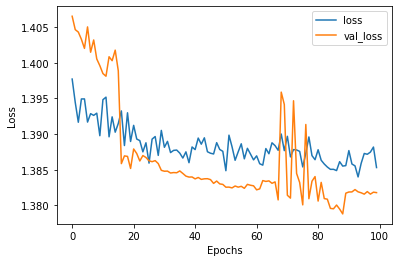

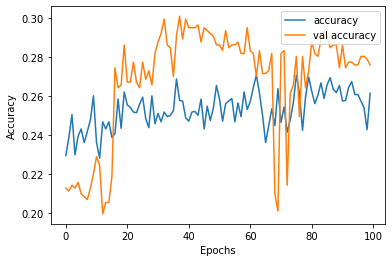

In [46]:
plot_learning_curve(history)

In [47]:
test_x = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=ytest
)

21/21 [==============================] - ETA: 0s - loss: 1.3890 - accuracy: 0.25 - ETA: 0s - loss: 1.3897 - accuracy: 0.20 - ETA: 0s - loss: 1.3920 - accuracy: 0.20 - ETA: 0s - loss: 1.3896 - accuracy: 0.22 - ETA: 0s - loss: 1.3872 - accuracy: 0.26 - ETA: 0s - loss: 1.3905 - accuracy: 0.24 - ETA: 0s - loss: 1.3914 - accuracy: 0.23 - ETA: 0s - loss: 1.3932 - accuracy: 0.23 - ETA: 0s - loss: 1.3923 - accuracy: 0.23 - ETA: 0s - loss: 1.3907 - accuracy: 0.24 - ETA: 0s - loss: 1.3905 - accuracy: 0.24 - 4s 191ms/step - loss: 1.3905 - accuracy: 0.2442


In [48]:
model_eval

[1.3904674053192139, 0.2441679686307907]

In [49]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    my_prediction = model.predict(padded_tokens['input_ids'])
    print(my_prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(prediction)]